# Convolutional Neural Network - Basics

Implementing convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and backward propagation. 

## Implementing the building blocks

- Convolution functions:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
- Pooling functions:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward
    

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

## Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

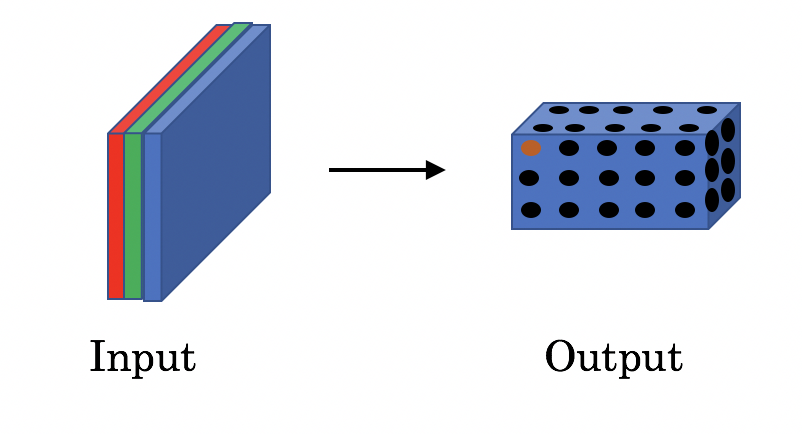

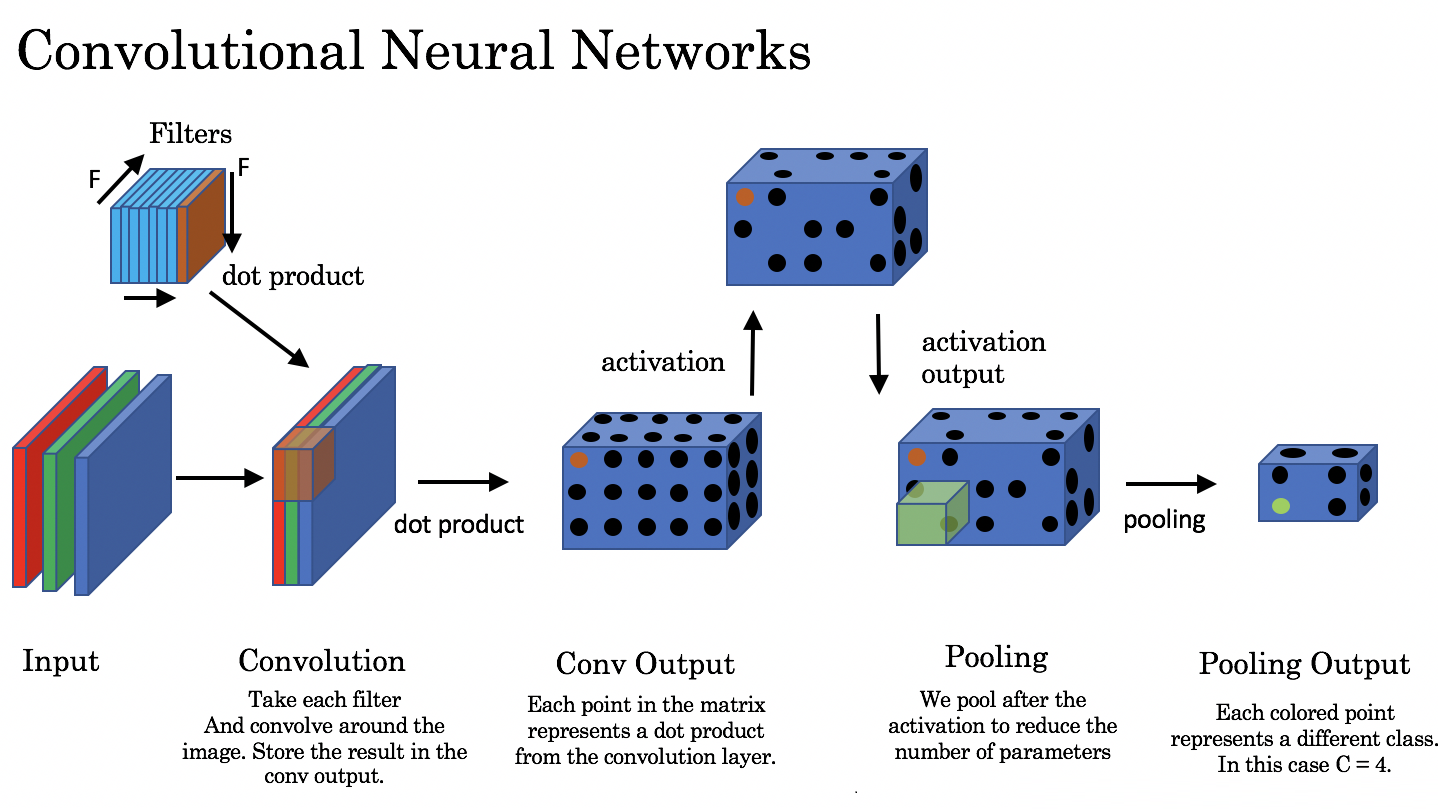

### Zero-Padding

Zero-padding adds zeros around the border of an image:

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

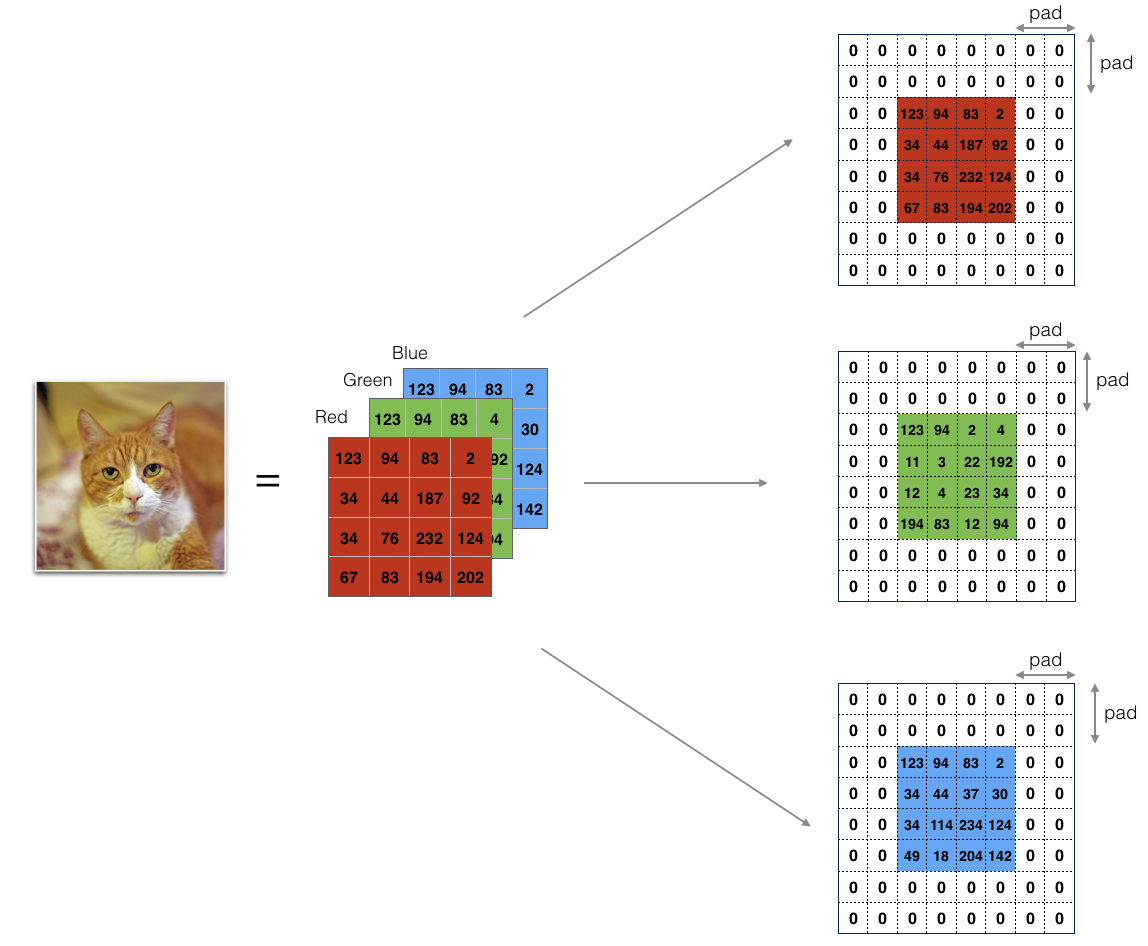

```python
def zero_pad(X, pad):
    X_pad = np.pad(X, 
                   ((0, 0),(pad, pad),(pad, pad),(0, 0)),
                   'constant', 
                   constant_values=(0, 0))    
    return X_pad
```

### Single step of convolution 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

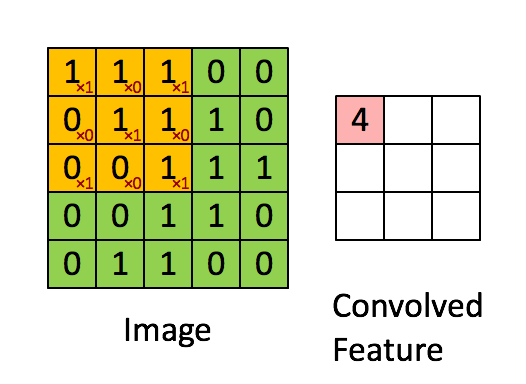

```python
def conv_single_step(a_slice_prev, W, b):
    # Element-wise product between a_slice and W. Add bias.
    s = np.multiply(a_slice_prev, W) + b
    # Sum over all entries of the volume s
    Z = np.sum(s)
    return Z
```

### Convolutional Neural Networks - Forward pass

In the forward pass, take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

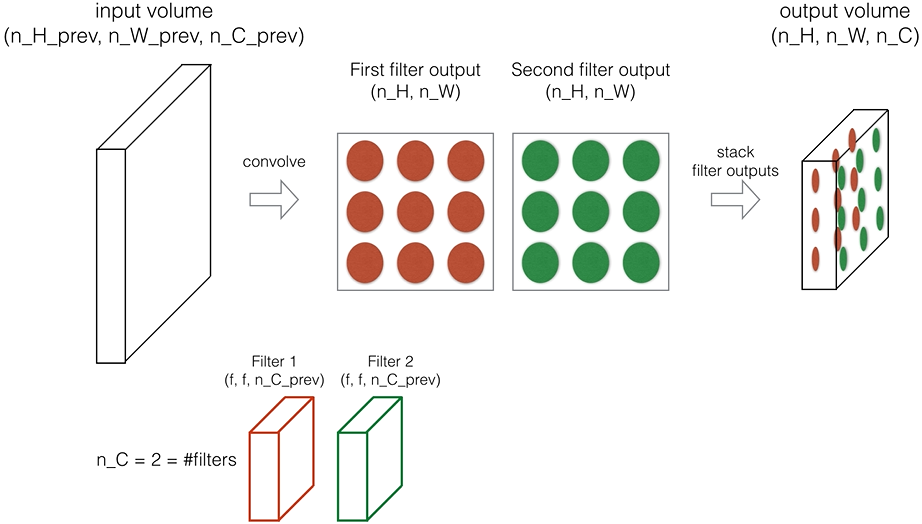

Function takes as input A_prev, the activations output by the previous layer (for a batch of m inputs), F filters/weights denoted by W, and a bias vector denoted by b, where each filter has its own (single) bias. Finally you also have access to the hyperparameters dictionary which contains the stride and the padding. 

1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
This is useful when you will define `a_slice_prev` using the `start/end` indexes.
2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find how each of the corner can be defined using h, w, f and s in the code below.

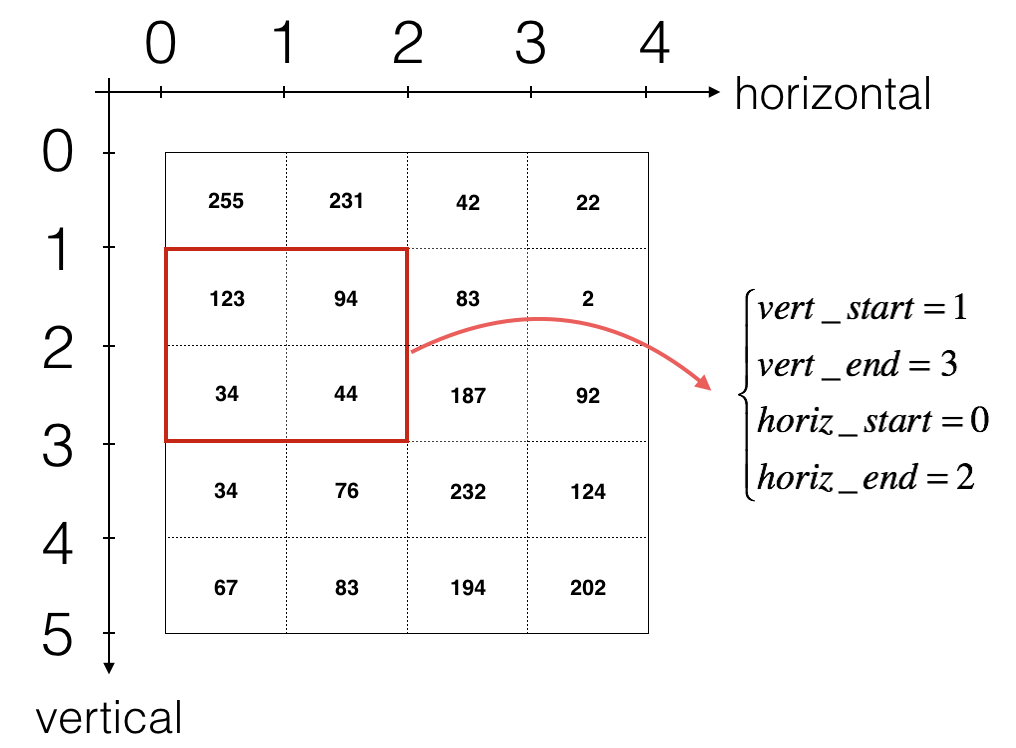

3. Finally, CONV layer should also contain an activation:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

**Formulas**: Output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$



```python
def conv_forward(A_prev, W, b, hparameters):
    #A_prev -- output activations of shape (m, n_H_prev, n_W_prev, n_C_prev)
    #W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    #b -- Biases, numpy array of shape (1, 1, 1, n_C)
    #hparameters -- python dictionary containing "stride" and "pad"

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
   
    n_H = int((n_H_prev - f + 2 * pad) / stride + 1)     
    n_W = int((n_W_prev - f + 2 * pad) / stride + 1)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):              # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i, :, :, :] # Select ith example's padded activation
        for h in range(n_H):        # loop over vertical axis of the output volume
            for w in range(n_W):    # loop over horizontal axis of the output volume
                for c in range(n_C):# loop over channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[vert_start: vert_end, 
                                              horiz_start: horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c],
                                                     b[:, :, :, c]) 
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache
```

## Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the fxf window you would compute a max or average over. 

### Forward Pooling
MAX-POOL and AVG-POOL
**Formulas**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

<table>
<td>
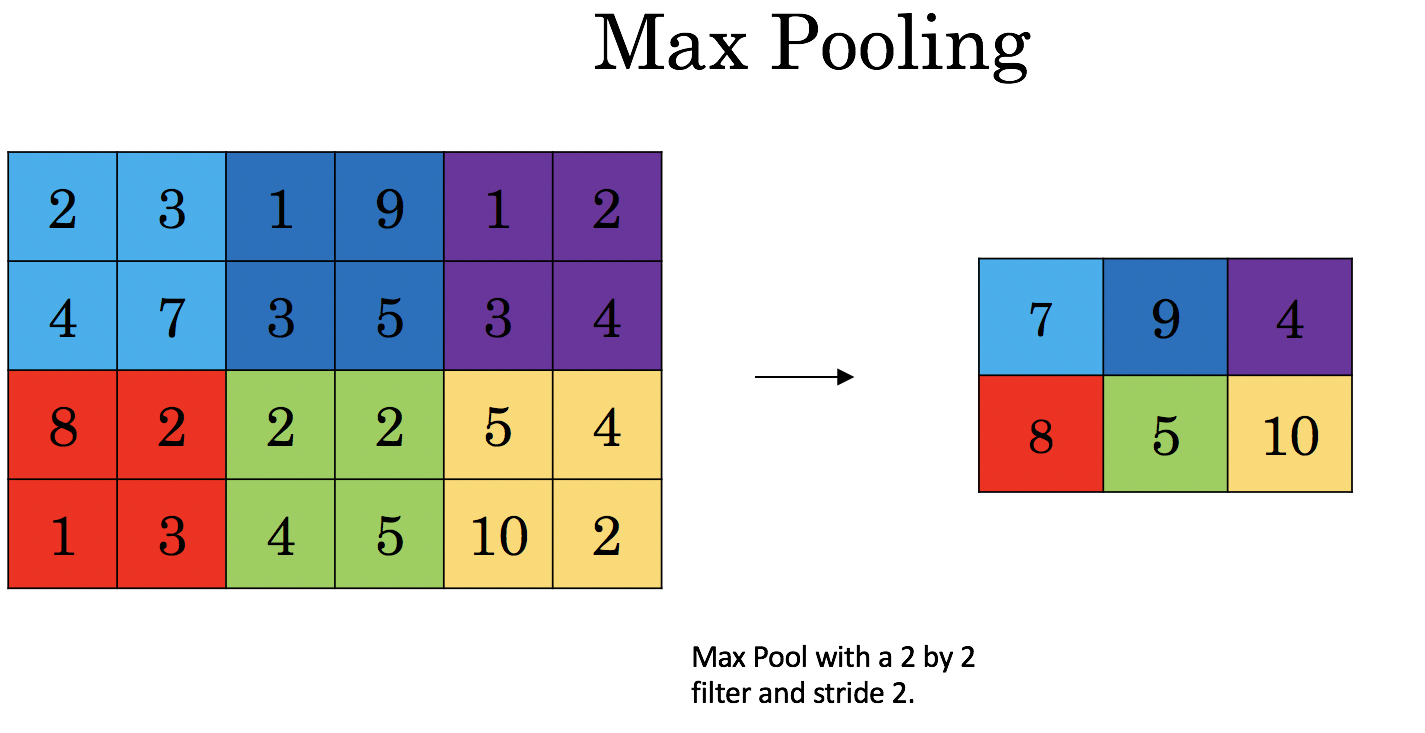
<td>
<td>
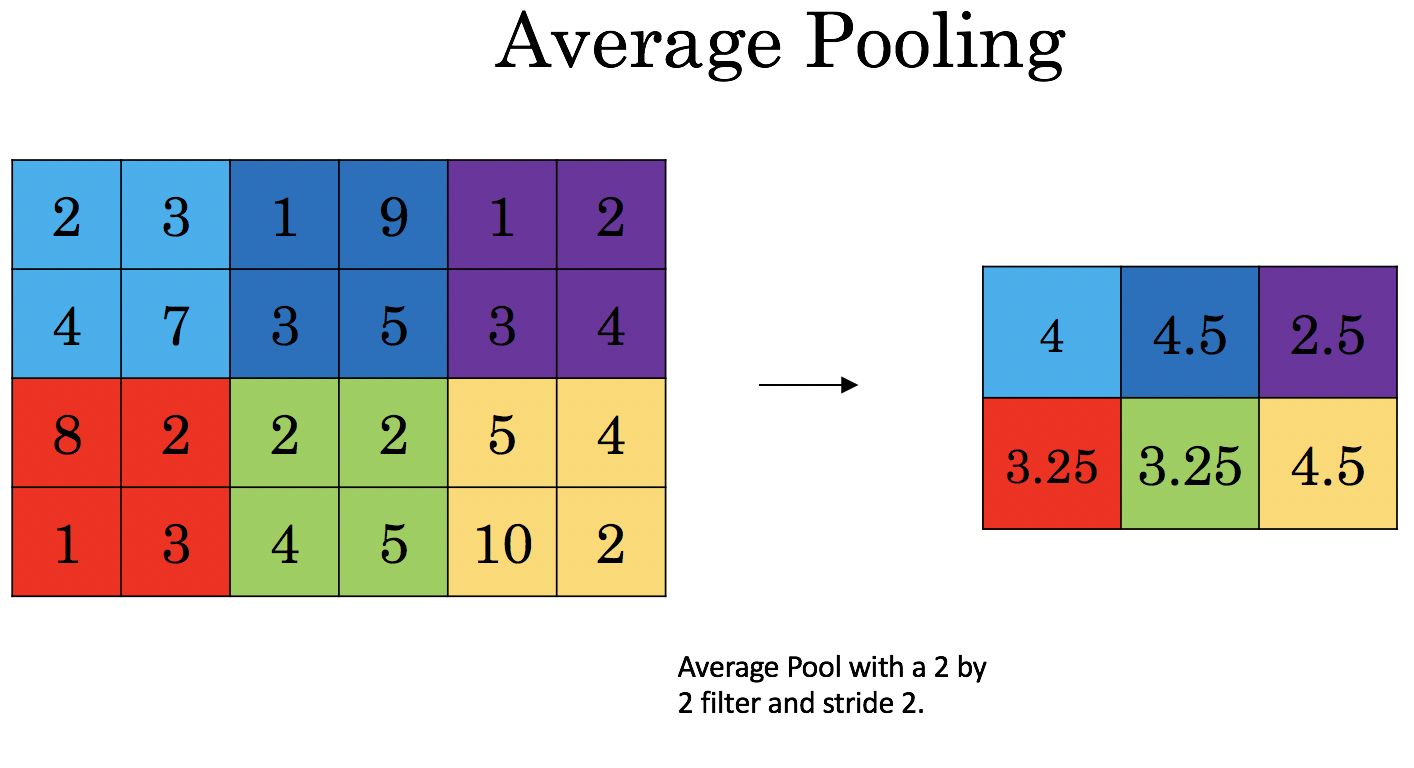
<td>
</table>

```python
def pool_forward(A_prev, hparameters, mode = "max"):
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):  # loop over the training examples
        for h in range(n_H):# loop on the vertical axis of the output volume
            for w in range(n_W):# loop on the horizontal axis of the output volume
                for c in range (n_C):  # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i, : , : , c]
                    # Compute the pooling operation on the slice
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice[vert_start:vert_end,
                                                            horiz_start:horiz_end])
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end,
                                                             horiz_start:horiz_end])
    
    cache = (A_prev, hparameters)
    return A, cache
```

## Backpropagation in convolutional neural networks

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. 

### Convolutional layer backward pass 


#### Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} $$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, 
            horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  $$

Where $a_{slice}$ corresponds to the slice which was used to generate the acitivation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} $$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```


```python
def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):  # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i, :, :, :]
        da_prev_pad = dA_prev_pad[i, :, :, :]
        
        for h in range(n_H):        # loop over vertical axis of the output volume
            for w in range(n_W):    # loop over horizontal axis of the output volume
                for c in range(n_C):# loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, 
                                         horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters
                    da_prev_pad[vert_start:vert_end, 
                                horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad 
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
        
    return dA_prev, dW, db
```

## Pooling layer - backward pass

### Max pooling - backward pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}$$

This function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). 



Why do we keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

```python
def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask
```

### Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

```python
def distribute_value(dz, shape):   
    # Retrieve dimensions from shape 
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix 
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value 
    a = np.ones(shape) * average
   
    return a
```

### Pooling backward 

```python
def pool_backward(dA, cache, mode = "max"):
    # Retrieve information from cache 
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" 
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape 
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros 
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):  # loop over the training examples
        
        # select training example from A_prev 
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):            # loop on the vertical axis
            for w in range(n_W):        # loop on the horizontal axis
                for c in range(n_C):    # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" 
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start: vert_end,
                                              horiz_start: horiz_end, c]
                        # Create the mask from a_prev_slice 
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev using the mask 
                        dA_prev[i, vert_start: vert_end,
                                horiz_start: horiz_end, c] += np.multiply(mask, 
                                                                          dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf 
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev
                        dA_prev[i, vert_start: vert_end,
                                horiz_start: horiz_end, c] += distribute_value(da, shape)
                            
    return dA_prev
```
